In [1]:
import os
import numpy as np
import pandas as pd
from scipy.io import loadmat
import h5py
from modAL.models import ActiveLearner
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rc('font',family='Times New Roman')

### Parameters

In [2]:
results_dir = os.path.join('output')
pd.options.display.max_rows = 500

### Load results

In [3]:
# create a converter that converts columns of lists from strings to actual list types
list_cols = ['baseline_cm', 'rand_cm', 'unisel_cm', 'al_cm', 'al_unisel_cm', \
             'rand_n_selected_outliers', 'rand_n_selected_normals', \
             'unisel_n_selected_outliers', 'unisel_n_selected_normals', \
             'al_n_selected_outliers', 'al_n_selected_normals', \
             'al_unisel_n_selected_outliers', 'al_unisel_n_selected_normals']
list_converter = {col:eval for col in list_cols}

In [4]:
files = os.listdir(results_dir)
files.sort()
df = pd.DataFrame()

for file in files: 
    if file.endswith('.csv'):
        df = df.append(pd.read_csv(os.path.join(results_dir, file), converters=list_converter), ignore_index=True)

list_cols = ['baseline_cm', 'rand_cm', 'unisel_cm', 'al_cm', 'al_unisel_cm'] # reset without counts of outliers and normals

In [5]:
df.loc[df['name'] == 'cover', 'name'] = 'forest cover'

In [6]:
# propagate forward the baseline confusion matrix
df.loc[df['baseline_cm'].str.len() == 0, 'baseline_cm'] = np.nan
df['baseline_cm'] = df['baseline_cm'].fillna(method='ffill')

### Investigate class ratios

In [7]:
def get_sample_ratios(x, list_col):
    cms = x[list_col]
    n_selected_outliers = x['_'.join(list_col.split('_')[:-1]) + '_n_selected_outliers']
    n_selected_normals = x['_'.join(list_col.split('_')[:-1]) + '_n_selected_normals']
    n_outliers = x['n_outliers']
    n_obs = x['n_obs']
    
    ratios = []
    
    for idx, cm in enumerate(cms):
        tn, fp, fn, tp = cm # unlabeled
        ratios.append(n_selected_outliers[idx] / n_selected_normals[idx])
    
    return np.mean(ratios), np.std(ratios)

In [8]:
df['overall_ratio'] = df['n_outliers'] / (df['n_obs'] - df['n_outliers'])

for list_col in list_cols[1:5]:
    results = df.apply(lambda x: get_sample_ratios(x, list_col) if x[list_col] else (None, None), axis=1)
    list_col_prefix = list_col.split('_cm')[0]
    df[[list_col_prefix + '_selected_ratio_mean', list_col_prefix + '_selected_ratio_sd']] = \
        pd.DataFrame(results.tolist(), index=df.index)

### Create tables and figures

In [9]:
mean_cols = ['baseline_mean', 'rand_mean', 'unisel_mean', 'al_mean', 'al_unisel_mean']

In [10]:
def bold_max(s):
    is_max = s == s.max()
    return ['font-weight: bold' if v else '' for v in is_max]

In [11]:
def performance(cms):
    f1 = []
    
    for cm in cms:
        tn, fp, fn, tp = cm
        f1.append(tp / (tp + 0.5 * (fp + fn)))
    
    return np.mean(f1), np.std(f1)

In [12]:
# summarize performance metrics
for list_col in list_cols:
    results = df[list_col].apply(lambda x: performance(np.array(x)) if x else (None, None))
    list_col_prefix = list_col.split('_cm')[0]
    df[[list_col_prefix + '_mean', list_col_prefix + '_sd']] = \
        pd.DataFrame(results.tolist(), index=df.index)

In [13]:
# truncate floats
num_cols = mean_cols + [x.replace('mean', 'sd') for x in mean_cols]
df[num_cols] = df[num_cols].apply(lambda x: np.floor(1000 * x) / 1000)

In [14]:
# clean up and format
df.drop(columns=list_cols, inplace=True)
df.sort_values(['n_samples', 'name'], inplace=True)
df.reset_index(drop=True, inplace=True)

group_cols = ['baseline', 'rand', 'unisel', 'al', 'al_unisel']

for group in group_cols:
    df[group] = df[group + '_mean'].astype('str') + ' (' + df[group + '_sd'].astype('str') + ')'
    
df.set_index(['n_samples', 'name']).style.apply(bold_max, subset=mean_cols, axis=1).format('{:.3f}', subset=num_cols)

In [15]:
# save to Excel file for further formatting
df.to_excel(os.path.join('manuscript', 'tables', 'table_2.xlsx'))

### Create results visualizations

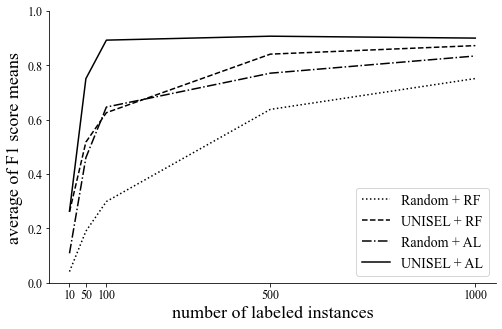

In [16]:
experiments = ['rand', 'unisel', 'al', 'al_unisel']
rename_dict = {'rand':'Random + RF', 'unisel':'UNISEL + RF', 'al':'Random + AL', 'al_unisel':'UNISEL + AL'}
line_styles = ['dotted', 'dashed', 'dashdot', 'solid']
n_instances = [10, 50, 100, 500, 1000]
n_instances_experiments = len(n_instances)
n_datasets = df['name'].nunique()

plt.figure(figsize=(8,5))

for idx, experiment in enumerate(experiments):
    mean_f1 = df[experiment + '_mean'].values.reshape(n_instances_experiments, n_datasets).mean(axis=1)
    plt.plot(n_instances, mean_f1, 'k', linestyle=line_styles[idx], label=rename_dict[experiment])

ax = plt.gca()
ax.set_xticks(n_instances)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.ylim(0., 1.0)
plt.legend(fontsize=14)
plt.xlabel('number of labeled instances', fontsize=18)
_ = plt.ylabel('average of F1 score means', fontsize=18)
plt.savefig(os.path.join('manuscript', 'figures', 'fig_1A.tiff'), dpi = 500)

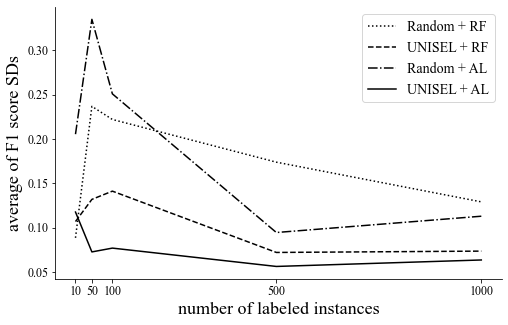

In [17]:
experiments = ['rand', 'unisel', 'al', 'al_unisel']
rename_dict = {'rand':'Random + RF', 'unisel':'UNISEL + RF', 'al':'Random + AL', 'al_unisel':'UNISEL + AL'}
line_styles = ['dotted', 'dashed', 'dashdot', 'solid']
n_instances = [10, 50, 100, 500, 1000]
n_instances_experiments = len(n_instances)
n_datasets = df['name'].nunique()

plt.figure(figsize=(8,5))

for idx, experiment in enumerate(experiments):
    mean_f1 = df[experiment + '_sd'].values.reshape(n_instances_experiments, n_datasets).mean(axis=1)
    plt.plot(n_instances, mean_f1, 'k', linestyle=line_styles[idx], label=rename_dict[experiment])

ax = plt.gca()
ax.set_xticks(n_instances)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.legend(fontsize=14)
plt.xlabel('number of labeled instances', fontsize=18)
_ = plt.ylabel('average of F1 score SDs', fontsize=18)
plt.savefig(os.path.join('manuscript', 'figures', 'fig_1B.tiff'), dpi = 500)

This plot above is quite interesting. Unisel reduces variance as the number of labeled instances increases, but the opposite is seen with non-unisel methods.

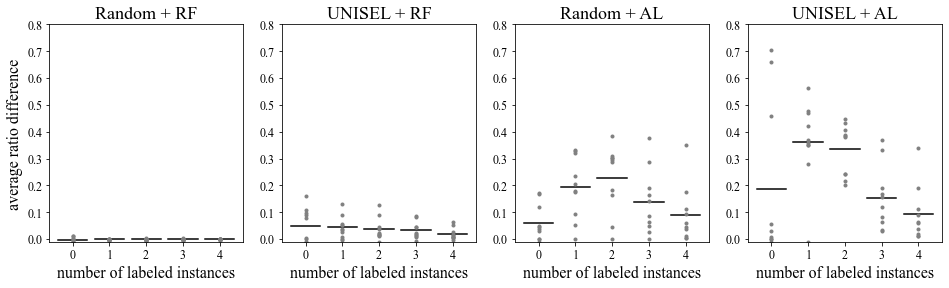

In [18]:
experiment_means = []
experiment_sds = []
experiment_pts = []

for experiment in experiments:
    means = []
    sds = []
    pts = []
    
    for n in n_instances:
        df_temp = df[df['n_samples'] == n].copy()
        
        ratios = df_temp[experiment + '_selected_ratio_mean'].values
        overall_ratios = df_temp['overall_ratio'].values
        
        means.append(np.mean(ratios - overall_ratios))
        sds.append(np.std(ratios - overall_ratios))
        pts.append(ratios - overall_ratios)
    
    experiment_means.append(means)
    experiment_sds.append(np.vstack([np.zeros((1, len(n_instances))), sds]))
    experiment_pts.append(pts)

min_val = -0.01
max_val = 0.8
plt.figure(figsize=(16,4))

for idx,experiment in enumerate(experiments):
    plt.subplot(1,len(experiments), idx+1)
    #plt.bar(np.arange(len(n_instances)), experiment_means[idx], yerr=experiment_sds[idx], capsize=10, tick_label=n_instances)
    bardata = plt.bar(np.arange(len(n_instances)), experiment_means[idx], color='w')
    
    for b in bardata:
        w,h = b.get_width(), b.get_height()
        # lower left vertex
        x0, y0 = b.xy
        # lower right vertex
        x1, y1 = x0+w,y0
        # top left vertex
        x2, y2 = x0,y0+h
        # top right vertex
        x3, y3 = x0+w,y0+h
        plt.plot([x2, x3], [y2, y3], 'k')
    
    for idx2, n in enumerate(n_instances):
        plt.plot([idx2]*10, experiment_pts[idx][idx2], '.', color='gray')
    
    plt.title(rename_dict[experiment], fontsize=18)
    plt.ylim(min_val, max_val)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    
    if idx == 0:
        plt.ylabel('average ratio difference', fontsize=16)
    
    plt.xlabel('number of labeled instances', fontsize=16)

plt.savefig(os.path.join('manuscript', 'figures', 'fig_4.tiff'), dpi = 500)

There is some positive correlation between performance and percentage of outliers in the data set for AL. I don't really know what this means that it is only for AL. One of the concerns with looking for correlations is that there are upper and lower limits with F1 that mess things up. Maybe don't report this because it's unclear.

In [19]:
def unisel(data_X, n_instances, seed):
    ss = StandardScaler()
    kmeans = KMeans(n_clusters=n_instances, n_init=1, random_state=seed)
    labels = kmeans.fit_predict(ss.fit_transform(data_X))
    unique_labels = list(set(labels))
    sample_idx = []
    
    for label in unique_labels:
        instance_idx = np.where(labels == label)[0]
        dist = np.sqrt(np.sum((ss.transform(data_X[instance_idx]) - 
                    kmeans.cluster_centers_[label])**2, axis=-1))
        sample_idx.append(instance_idx[np.argmin(dist)])
    
    nonsample_idx = list(set(np.arange(data_X.shape[0])) -
                     set(sample_idx))
        
    return sample_idx, nonsample_idx

In [20]:
def active_learning(model, data_X, data_y, sample_idx, n_iter):
    nonsample_idx = np.array(list(set(np.arange(data_X.shape[0])) - set(sample_idx)))
    learner = ActiveLearner(model, X_training=data_X[sample_idx], y_training=data_y[sample_idx])
    
    for al_idx in range(n_iter):                    
        # query for labels
        query_idx, _ = learner.query(data_X[nonsample_idx])
        
        # supply label for queried instance
        learner.teach(data_X[nonsample_idx][query_idx], data_y[nonsample_idx][query_idx])
        
        sample_idx.append(nonsample_idx[query_idx][0])
        nonsample_idx = np.array(list(set(np.arange(data_X.shape[0])) - set(sample_idx)))
    
    return sample_idx, nonsample_idx

In [21]:
def visualize(exp_name, dataset_name, X, y, X_test, y_test, y_pred, sample_idx, nonsample_idx):    
    plt.figure(figsize=(22,5))
    f1 = np.floor(1000 * f1_score(y_test, y_pred)) / 1000
    f1 = str('%.3f' % f1)
    
    plt.subplot(1,4,1)
    plt.plot(X[:,0], X[:,1], '.', color='0.75')
    plt.title('Training Instances', fontsize=20)
    plt.gca().axes.xaxis.set_visible(False)
    plt.gca().axes.yaxis.set_visible(False)
    xlim = plt.gca().get_xlim()
    ylim = plt.gca().get_ylim()
    
    plt.subplot(1,4,2)
    plt.plot(X[sample_idx][y[sample_idx] == 0,0], X[sample_idx][y[sample_idx] == 0,1], '.', color='#0f2080')
    plt.plot(X[sample_idx][y[sample_idx] == 1,0], X[sample_idx][y[sample_idx] == 1,1], '.', color='#f46a25')
    plt.title('Labeled Training Instances\n(' + exp_name + ')', fontsize=20)
    plt.gca().axes.xaxis.set_visible(False)
    plt.gca().axes.yaxis.set_visible(False)
    plt.xlim(xlim)
    plt.ylim(ylim)

    plt.subplot(1,4,3)
    plt.plot(X_test[y_pred == 0,0], X_test[y_pred == 0,1], '.', color='#0f2080')
    plt.plot(X_test[y_pred == 1,0], X_test[y_pred == 1,1], '.', color='#f46a25')
    plt.title('Predicted Testing Instances\n(F1 = ' + f1 + ')', fontsize=20)
    plt.gca().axes.xaxis.set_visible(False)
    plt.gca().axes.yaxis.set_visible(False)
    plt.xlim(xlim)
    plt.ylim(ylim)
    
    plt.subplot(1,4,4)
    plt.plot(X_test[y_test == 0,0], X_test[y_test == 0,1], '.', color='#0f2080')
    plt.plot(X_test[y_test == 1,0], X_test[y_test == 1,1], '.', color='#f46a25')
    plt.title('Ground Truth Testing Instances', fontsize=20)
    plt.gca().axes.xaxis.set_visible(False)
    plt.gca().axes.yaxis.set_visible(False)
    plt.xlim(xlim)
    plt.ylim(ylim)

In [22]:
def run_al_unisel(dataset, sample_size, seed):
    # load data
    data_file = os.path.join('data', dataset)
    
    try:
        data = loadmat(data_file)
    except:
        with h5py.File(data_file, 'r') as f:
            data = {'X':None, 'y':None}
            data['X'] = f['X'][:].T
            data['y'] = f['y'][:].T
    
    y = data['y'].ravel()
    
    # shuffle data
    np.random.seed(seed)
    X = data['X']
    y = data['y'].ravel()
    X, X_test, y, y_test = train_test_split(X, y, test_size=0.10,
                random_state=seed, shuffle=True, stratify=y)
    
    # define models
    rf = RandomForestClassifier(n_estimators=100, class_weight=None, 
                                n_jobs=-1, random_state=seed)
    
    ####### Active Learning Method (unisel initialization) #######
    first_half_sample_size = int(np.floor(sample_size/2))
    second_half_sample_size = int(np.ceil(sample_size/2))
    
    sample_idx, _ = unisel(X, first_half_sample_size, seed)
    sample_idx, nonsample_idx = active_learning(rf, X, y, sample_idx,
                                                n_iter=second_half_sample_size)
    
    # train and predict
    rf.fit(X[sample_idx], y[sample_idx])
    y_pred = rf.predict(X_test)
    
    # project to 2D space
    ss = StandardScaler()
    pca = PCA(n_components=2, random_state=seed)
    X = pca.fit_transform(ss.fit_transform(X))
    X_test = pca.transform(ss.transform(X_test))
    
    visualize('UNISEL + AL', dataset, X, y, X_test, y_test, y_pred, sample_idx, nonsample_idx)

In [23]:
def run_random(dataset, sample_size, seed):
    # load data
    data_file = os.path.join('data', dataset)
    
    try:
        data = loadmat(data_file)
    except:
        with h5py.File(data_file, 'r') as f:
            data = {'X':None, 'y':None}
            data['X'] = f['X'][:].T
            data['y'] = f['y'][:].T
    
    y = data['y'].ravel()
    
    # shuffle data
    np.random.seed(seed)
    X = data['X']
    y = data['y'].ravel()
    X, X_test, y, y_test = train_test_split(X, y, test_size=0.10,
                random_state=seed, shuffle=True, stratify=y)
    
    # define models
    rf = RandomForestClassifier(n_estimators=100, class_weight=None, 
                                n_jobs=-1, random_state=seed)
    
    ####### Random Sampling #######
    sample_idx = np.random.choice(X.shape[0], size=sample_size,
                                  replace=False).tolist()
    nonsample_idx = list(set(np.arange(X.shape[0])) -
                         set(sample_idx))
    
    # train and predict
    rf.fit(X[sample_idx], y[sample_idx])
    y_pred = rf.predict(X_test)
    
    # project to 2D space
    ss = StandardScaler()
    pca = PCA(n_components=2, random_state=seed)
    X = pca.fit_transform(ss.fit_transform(X))
    X_test = pca.transform(ss.transform(X_test))
    
    visualize('Random + RF', dataset, X, y, X_test, y_test, y_pred, sample_idx, nonsample_idx)

In [24]:
def plot_title_and_legend(dataset, sample_size):
    plt.figure(figsize=(22,5))
    plt.title(dataset.split('.')[0] + ' with ' + str(sample_size) + ' Labeled Instances', fontsize=24)
    plt.plot([1], [1], '.', markersize=16, color='0.75', label='unlabeled')
    plt.plot([1], [1], '.', color='#0f2080', markersize=16, label='non-outlier')
    plt.plot([1], [1], '.', color='#f46a25', markersize=16, label='outlier')
    _ = plt.legend(fontsize=20, ncol=3)    

Wall time: 10.3 s


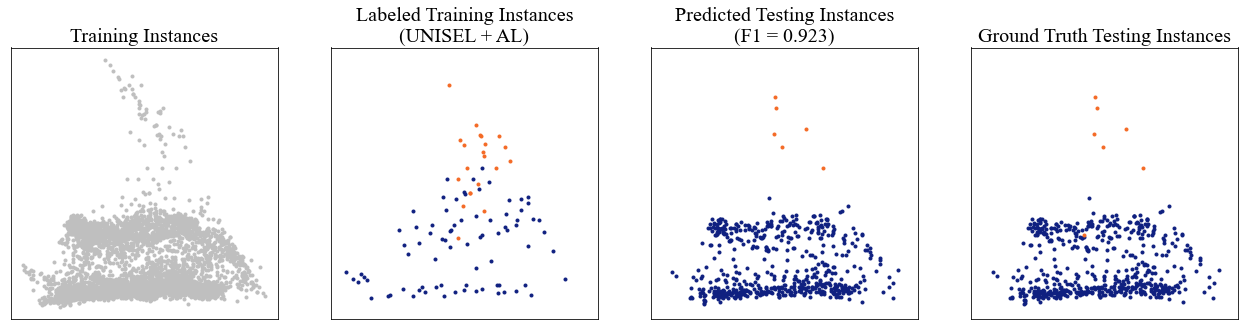

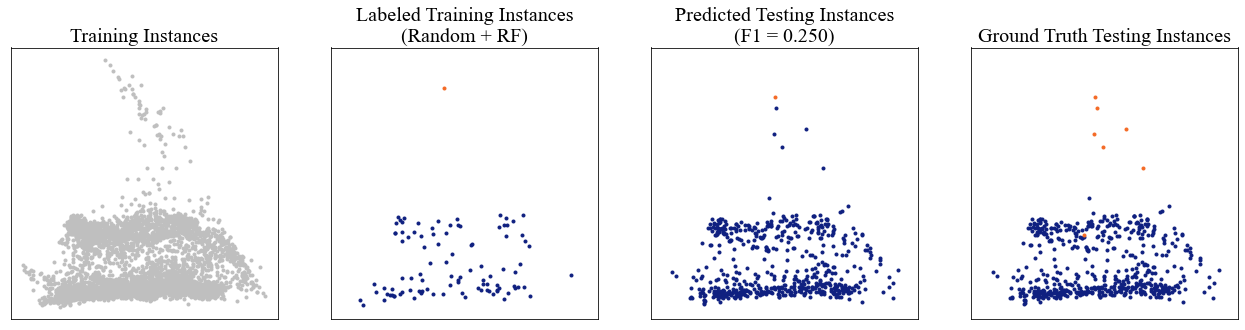

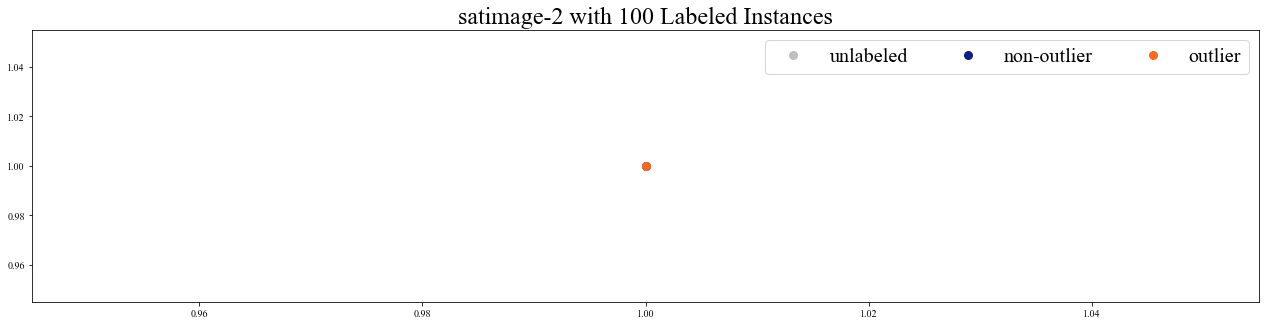

In [25]:
%%time

sample_size = 100
seed = 2

for dataset in ['satimage-2']:#df['name'].unique():
    run_al_unisel(dataset+'.mat', sample_size, seed)
    plt.savefig(os.path.join('manuscript', 'figures', 'fig_2A.tiff'), dpi = 500)
    run_random(dataset+'.mat', sample_size, seed)
    plt.savefig(os.path.join('manuscript', 'figures', 'fig_2B.tiff'), dpi = 500)
    plot_title_and_legend(dataset+'.mat', sample_size)
    plt.savefig(os.path.join('manuscript', 'figures', 'fig_2_legend.tiff'), dpi = 500)

In [26]:
for experiment in experiments:
    df[experiment + '_pct_chg'] = 100 * (df[experiment + '_mean'] - df['baseline_mean']) / df['baseline_mean']

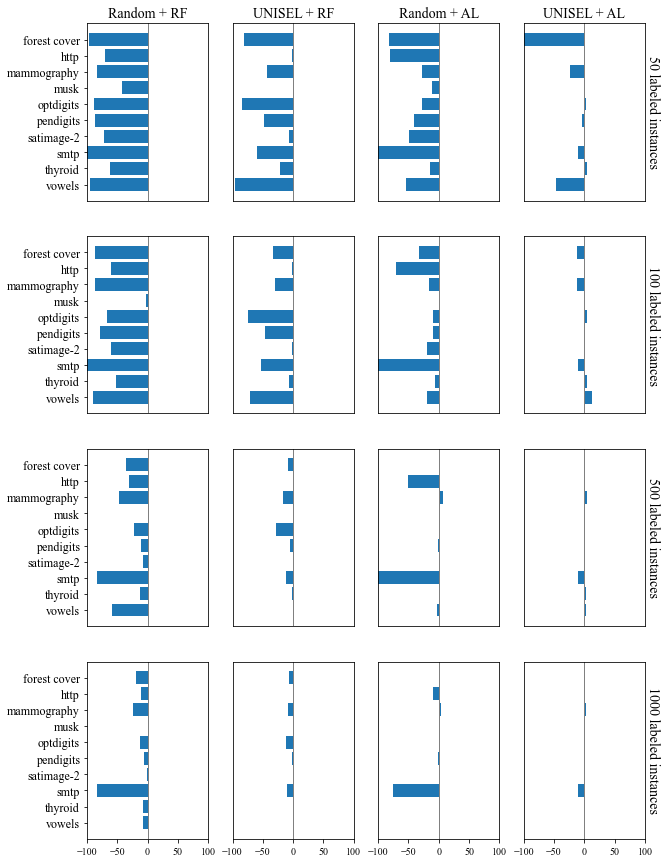

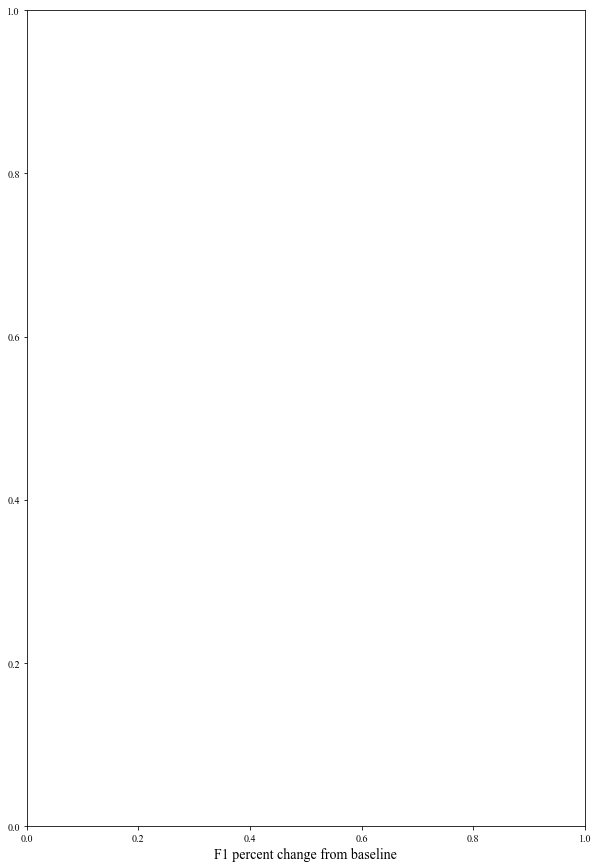

In [27]:
plt.figure(figsize=(10, 15))

for idx, n in enumerate([50, 100, 500, 1000]):
    df_temp = df.loc[df['n_samples'] == n, ['name'] + list(df.columns[df.columns.str.contains('pct_chg')])].copy()
    df_temp = df_temp.sort_values('name', ascending=False)
    plt.subplot(4,4,1+4*idx)
    plt.barh(df_temp['name'], df_temp['rand_pct_chg'])
    plt.plot([0, 0], [-1, 10], 'gray', linewidth=1)
    plt.yticks(fontsize=12)
    plt.xlim(-100, 100)
    plt.ylim(-1, 10)
    
    if idx == 0:
        plt.title('Random + RF', fontsize=14)
    
    if idx < 3:
        plt.gca().axes.xaxis.set_visible(False)    
        
    plt.subplot(4,4,2+4*idx)
    plt.barh(df_temp['name'], df_temp['unisel_pct_chg'])
    plt.plot([0, 0], [-1, 10], 'gray', linewidth=1)
    plt.yticks(fontsize=12)
    plt.xlim(-100, 100)
    plt.ylim(-1, 10)
    
    if idx == 0:
        plt.title('UNISEL + RF', fontsize=14)
    
    if idx < 3:
        plt.gca().axes.xaxis.set_visible(False)    
    
    plt.gca().axes.yaxis.set_visible(False)
    plt.subplot(4,4,3+4*idx)
    plt.barh(df_temp['name'], df_temp['al_pct_chg'])
    plt.plot([0, 0], [-1, 10], 'gray', linewidth=1)
    plt.yticks(fontsize=12)
    plt.xlim(-100, 100)
    plt.ylim(-1, 10)
    
    if idx == 0:
        plt.title('Random + AL', fontsize=14)
    
    if idx < 3:
        plt.gca().axes.xaxis.set_visible(False)    
    
    plt.gca().axes.yaxis.set_visible(False)
    plt.subplot(4,4,4+4*idx)
    plt.barh(df_temp['name'], df_temp['al_unisel_pct_chg'])
    plt.plot([0, 0], [-1, 10], 'gray', linewidth=1)
    plt.yticks(fontsize=12)
    plt.xlim(-100, 100)
    plt.ylim(-1, 10)
    
    if idx == 0:
        plt.title('UNISEL + AL', fontsize=14)
    
    if idx < 3:
        plt.gca().axes.xaxis.set_visible(False)
    
    plt.gca().axes.yaxis.set_ticks([])
    plt.gca().axes.yaxis.set_label_position('right')
    plt.ylabel(str(n) + ' labeled instances', fontsize=14, rotation=270, labelpad=15)

plt.savefig(os.path.join('manuscript', 'figures', 'fig_3.tiff'), dpi = 500)

plt.figure(figsize=(10, 15))
plt.xlabel('F1 percent change from baseline', fontsize=14)
plt.savefig(os.path.join('manuscript', 'figures', 'fig_3_label.tiff'), dpi = 500)